/home/abhishek/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)


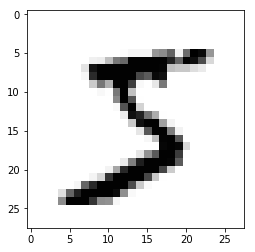

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


In [3]:
import tensorflow as tf
import numpy as np
import math
from tensorflow.python.framework import ops

In [4]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T
print(X_train_flatten.shape)
print(X_val_flatten.shape)
print(X_test_flatten.shape)

(784, 50000)
(784, 10000)
(784, 10000)


In [5]:
def one_hot_matrix(labels, C):


    depth = tf.constant(C, name = "C")
    
    one_hot_matrix = tf.one_hot(labels, depth, axis = 0)
    
    sess = tf.Session()
    
    one_hot = sess.run(one_hot_matrix)
    
    sess.close()
        
    return one_hot

In [6]:
y_train_one_hot = one_hot_matrix(y_train, 10)
y_val_one_hot = one_hot_matrix(y_val, 10)
y_test_one_hot = one_hot_matrix(y_test, 10)
print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(10, 50000)
(10, 10000)
(10, 10000)


In [7]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    
    return X, Y

In [27]:
def initialize_parameters():

    tf.set_random_seed(1)                 

    W1 = tf.get_variable("W1", [50,784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [50,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [10,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [10,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [10,1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [24]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [30]:
def compute_cost(Z3, Y):

    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    

    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [28]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.0001,
          num_epochs = 450, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    

    X, Y = create_placeholders(n_x, n_y)

    parameters = initialize_parameters()

    Z2 = forward_propagation(X, parameters)

    cost = compute_cost(Z2, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch               
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            


        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Validation Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0: 1.167475
Cost after epoch 100: 0.013278
Cost after epoch 200: 0.000288
Cost after epoch 300: 0.000011
Cost after epoch 400: 0.000001


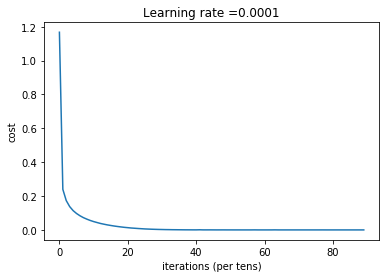

Parameters have been trained!
Train Accuracy: 1.0
Validation Accuracy: 0.9671


In [31]:
parameters = model(X_train_flatten, y_train_one_hot, X_val_flatten, y_val_one_hot)

In [32]:
with tf.Session() as sess:
    n_x = 784
    n_y = 10
    X, Y = create_placeholders(n_x, n_y)
    Z2 = forward_propagation(X, parameters)
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Test Accuracy:", accuracy.eval({X: X_test_flatten, Y: y_test_one_hot}))

Test Accuracy: 0.9681
